In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

2024-09-02 17:08:12.944032: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 17:08:12.960474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 17:08:12.980022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 17:08:12.985523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 17:08:12.999920: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Coleta de Dados Históricos (10 anos)
btc = yf.Ticker("BTC-USD")
btc_data = btc.history(period="10y")

In [4]:
# Usar apenas a coluna 'Close' para previsão
data = btc_data[["Close"]]

In [5]:
# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [6]:
# Criar as sequências para o modelo LSTM
sequence_length = 60  # Usaremos 60 dias de histórico para prever o próximo dia
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length : i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

In [7]:
# Redimensionar X para ter a forma [amostras, sequência temporal, número de features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Obter as datas correspondentes para y
y_dates = btc_data.index[sequence_length:]

In [8]:
# Divisão dos Dados (80% treino, 20% teste)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
y_dates_train, y_dates_test = y_dates[:split], y_dates[split:]

In [9]:
# Construção do Modelo LSTM
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=100))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")

/home/rafa/pondm7/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Treinamento do modelo
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0100
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 5.7774e-04
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 4.8241e-04
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 3.9280e-04
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 4.7744e-04
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 4.5920e-04
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 4.5479e-04
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 3.5376e-04
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 3.0669e-04
Epoch 10/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 2.6581e-04
Epoch 11/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 2.2860e-04
Epoch 12/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 2.6382e-04
Epoch 13/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 2.8796e-04
Epoch 14/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 2.0174e-04
Epoch 15/30
90/90 ━

In [11]:
# Fazer Previsões
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))

# Previsão dos próximos 30 dias
last_sequence = X_test[-1]  # Última sequência do conjunto de teste
predictions = []

for _ in range(30):
    pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    predictions.append(pred[0, 0])
    last_sequence = np.append(last_sequence[1:], pred)[-sequence_length:]
    last_sequence = last_sequence.reshape(sequence_length, 1)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Preços reais de teste para comparação
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Obter as datas para os próximos 30 dias
last_date = y_dates_test[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━

In [12]:
# Cálculo das Métricas do Modelo
mse = mean_squared_error(real_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_prices, predicted_prices)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Squared Error (MSE): 3030080.07
Root Mean Squared Error (RMSE): 1740.71
Mean Absolute Error (MAE): 1280.04


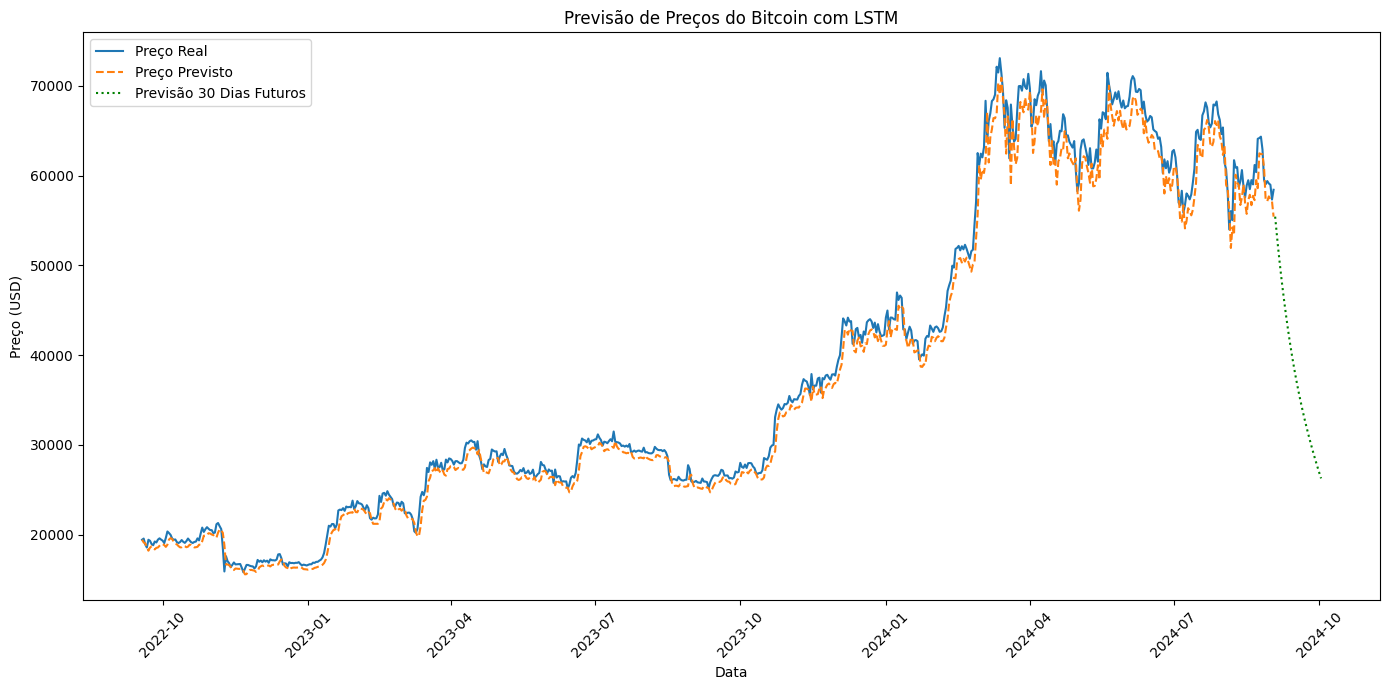

In [13]:
# Plotar o Gráfico de Previsão vs Real, incluindo os próximos 30 dias
plt.figure(figsize=(14, 7))
plt.plot(y_dates_test, real_prices, label="Preço Real")
plt.plot(y_dates_test, predicted_prices, label="Preço Previsto", linestyle="--")

# Adicionar as previsões dos próximos 30 dias ao gráfico
plt.plot(
    future_dates,
    predictions,
    label="Previsão 30 Dias Futuros",
    linestyle=":",
    color="green",
)

plt.title("Previsão de Preços do Bitcoin com LSTM")
plt.xlabel("Data")
plt.ylabel("Preço (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Identificação dos Melhores Dias para Comprar e Vender
buy_day_index = np.argmin(predictions)
sell_day_index = np.argmax(predictions)
buy_day = future_dates[buy_day_index]
sell_day = future_dates[sell_day_index]

print(f"Melhor dia para comprar Bitcoin: {buy_day.date()}")
print(f"Melhor dia para vender Bitcoin: {sell_day.date()}")

Melhor dia para comprar Bitcoin: 2024-10-02
Melhor dia para vender Bitcoin: 2024-09-03


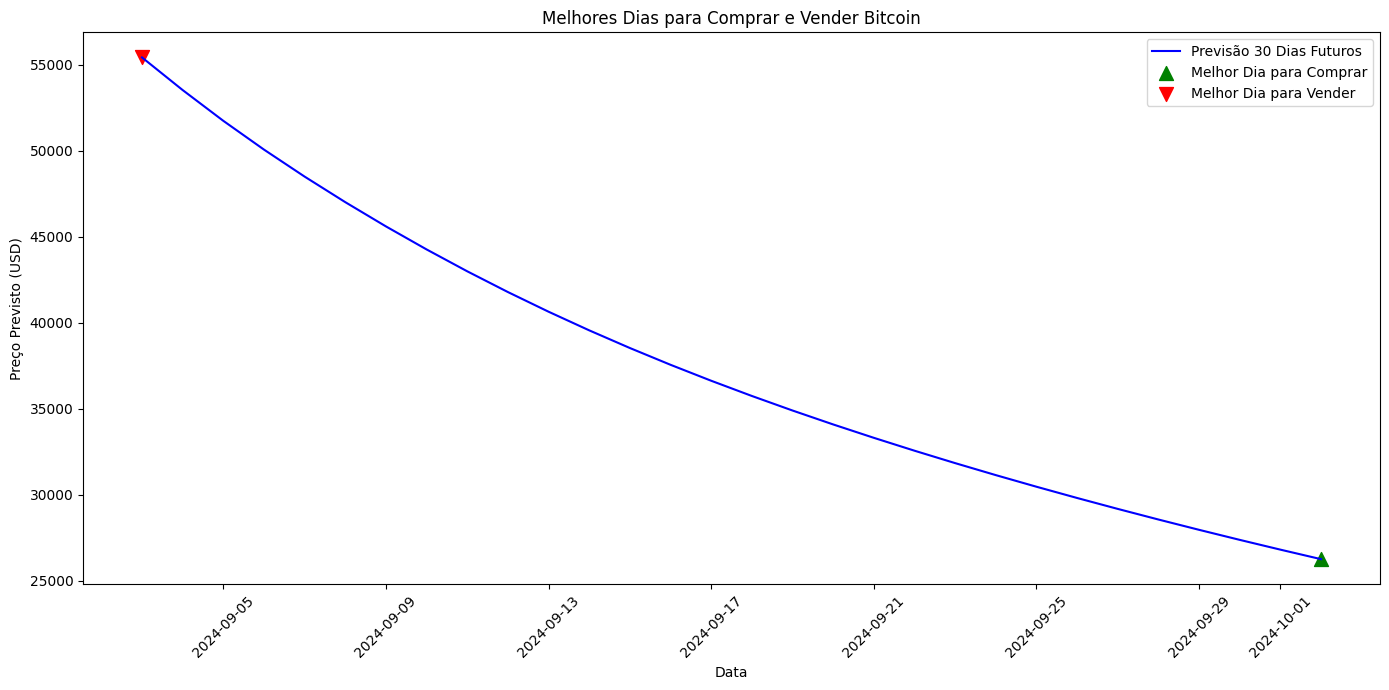

In [15]:
# Gráfico mostrando os melhores dias para compra e venda
plt.figure(figsize=(14, 7))
plt.plot(future_dates, predictions, label="Previsão 30 Dias Futuros", color="blue")
plt.scatter(buy_day, predictions[buy_day_index], color="green", label="Melhor Dia para Comprar", marker="^", s=100)
plt.scatter(sell_day, predictions[sell_day_index], color="red", label="Melhor Dia para Vender", marker="v", s=100)
plt.title("Melhores Dias para Comprar e Vender Bitcoin")
plt.xlabel("Data")
plt.ylabel("Preço Previsto (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()